# Анализ аренды самокатов

В данном проекте предстоит провести анализ данных сервиса аренды самокатов GoFast. Также проверить гипотезы, которые помогут бизнесу вырасти. Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:

*Без подписки*

абонентская плата отсутствует;
стоимость одной минуты поездки — 8 рублей;
стоимость старта (начала поездки) — 50 рублей;

*С подпиской Ultra*

абонентская плата — 199 рублей в месяц;
стоимость одной минуты поездки — 6 рублей;
стоимость старта — бесплатно.

**План работы:**

1. Проведем предобработку данных
2. Проведем исследовательский анализ данных
3. Объединим данные в общую таблицу и выделим группы пользователей с подпиской и без подписки в отдельные таблицы для анализа
4. Создадим датафрейм с агрегированными данными о поездках на основе объединенной таблицы и данных по подписке: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.
5. Оценим являются ли пользователи с подпиской более выгодными для компании, для этого проверим предварительно: тратят ли пользователи с подпиской больше времени на поездки; будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки; а также проверим среднее расстояние, которое проезжают пользователи с подпиской за одну поездку.
6. Сделать выводы.

**Описание данных**

**DataFrame "Пользователи"**

* user_id - уникальный идентификатор пользователя;
* name - имя пользователя;
* age - возраст;
* city - город;
* subscription_type - тип подписки (free, ultra);

**DataFrame "Поездки"**

* user_id - уникальный идентификатор пользователя;
* distance - расстояние, которое пользователь проехал в текущей сессии (в метрах);
* duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
* date - дата совершения поездки;

**DataFrame "Подписки"**

* subscription_type - тип подписки;
* minute_price - стоимость одной минуты поездки по данной подписке;
* start_ride_price - стоимость начала поездки;
* subscription_fee - стоимость ежемесячного платежа;

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st
from math import sqrt, factorial
from scipy.stats import binom, poisson, norm

In [5]:
# Функция общей информации датафрейма

def info(df):
    display(df.head(5))
    print()
    print('-' * 150)
    print()
    print('Общая информация:')
    display(df.info())
    print()
    print('-' * 150)
    print()
    display(df.describe())
    print()
    print('-' * 150)
    print()
    print('Количество пропусков для каждого столбца:')
    display(df.isnull().sum())

In [6]:
# Функция нахождения явных дубликатов

def dataset_isdub(dataset):
    print('Количество явных дубликатов в датасете:', dataset.duplicated().sum())
    percent = round(((dataset.duplicated().sum() / dataset.shape[0]) * 100), 0)
    print(f'Процент явных дубликатов в датасете: {percent}%')

In [7]:
# Добавляем столбец с помесячной выручкой, которую принёс каждый пользователь
# Помесячная выручка считается по формуле: 
# стоимость старта поездки × количество поездок + стоимость одной минуты поездки 
# × общая продолжительность всех поездок в минутах + стоимость подписки

def gain(row):
  gain_sum = 0
  gain_sum = (row['start_ride_price'] * row['count_distance'] +
              row['minute_price'] * row['sum_duration'] +
              row['subscription_fee']
              )
  return gain_sum

## Открываем файл с данными и изучаем общую информацию

In [9]:
try:
    users = pd.read_csv('users_go.csv')
    rides = pd.read_csv('rides_go.csv')
    subscriptions = pd.read_csv('subscriptions_go.csv')
except:
    users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

In [10]:
info(users)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra



------------------------------------------------------------------------------------------------------------------------------------------------------

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


None


------------------------------------------------------------------------------------------------------------------------------------------------------



,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000



------------------------------------------------------------------------------------------------------------------------------------------------------

Количество пропусков для каждого столбца:


user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [11]:
info(rides)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28



------------------------------------------------------------------------------------------------------------------------------------------------------

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


None


------------------------------------------------------------------------------------------------------------------------------------------------------



,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963



------------------------------------------------------------------------------------------------------------------------------------------------------

Количество пропусков для каждого столбца:


user_id     0
distance    0
duration    0
date        0
dtype: int64

In [12]:
info(subscriptions)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199



------------------------------------------------------------------------------------------------------------------------------------------------------

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


None


------------------------------------------------------------------------------------------------------------------------------------------------------



,minute_price,start_ride_price,subscription_fee
count,2.000000,2.000000,2.000000
mean,7.000000,25.000000,99.500000
std,1.414214,35.355339,140.714249
min,6.000000,0.000000,0.000000
25%,6.500000,12.500000,49.750000
50%,7.000000,25.000000,99.500000
75%,7.500000,37.500000,149.250000
max,8.000000,50.000000,199.000000



------------------------------------------------------------------------------------------------------------------------------------------------------

Количество пропусков для каждого столбца:


subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**Вывод:**

1. В трех полученных датафреймах отсутствуют пропуски.
2. Стоит обратить внимание на тип данных в колонке и изменить его на тип дата.

## Предобработка данных

In [15]:
dataset_isdub(users)

Количество явных дубликатов в датасете: 31
Процент явных дубликатов в датасете: 2.0%


In [16]:
dataset_isdub(rides)

Количество явных дубликатов в датасете: 0
Процент явных дубликатов в датасете: 0.0%


In [17]:
dataset_isdub(subscriptions)

Количество явных дубликатов в датасете: 0
Процент явных дубликатов в датасете: 0.0%


In [18]:
users = users.drop_duplicates()

In [19]:
print('Список уникальных наименований населенных пунктов:', users['city'].nunique())
print(users['city'].value_counts())

Список уникальных наименований населенных пунктов: 8
city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64


In [20]:
rides.date = pd.to_datetime(rides.date, format='%Y-%m-%d')
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [21]:
rides['month'] = rides.date.dt.month
display(rides.head())
print('Период дат из df: c', rides.date.min(),'по', rides.date.max())

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Период дат из df: c 2021-01-01 00:00:00 по 2021-12-30 00:00:00


**Вывод:**

1. Явные дубликаты встречаются только в датасете с пользователями, их процент составляет 2% от всего датафрейма - они были удалены.
2. Также рассмотрены уникальные названия городов на наличие опечаток или ошибок - все в порядке, ошибки не замечены.
3. Формат в стоблце с датой был конвертирован в дату.
4. Был создан столбец с месяцами - это понадобится нам для дальнейшего анализа.

## Исследовательский анализ данных

### Частота встречаемости городов

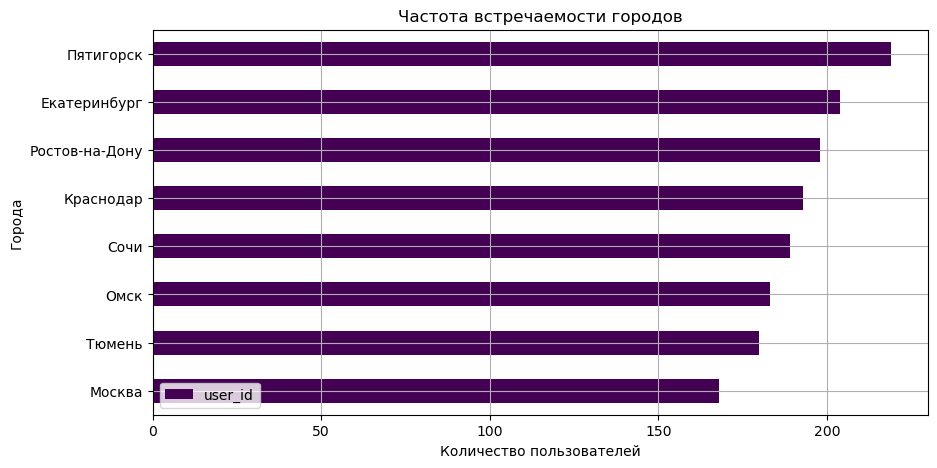

,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [25]:
users_city = users.pivot_table(index='city', values='user_id', aggfunc='count')
users_city = users_city.sort_values(by='user_id', ascending=True)

colors = plt.cm.viridis(range(len(users_city)))
users_city.plot(kind='barh', figsize=(10, 5), grid=True, color=colors)

plt.title('Частота встречаемости городов')
plt.xlabel('Количество пользователей')
plt.ylabel('Города')
plt.legend(loc='lower left')
plt.show()

display(users_city.sort_values(by='user_id', ascending = False))

**Вывод:**

*Лидеры по использованию самокатов:* Пятигорск занимает первое место с 219 зафиксированными случаями использования самокатов, что указывает на высокую популярность этого вида транспорта в городе. 

*Высокие показатели:* Екатеринбург (204) и Ростов-на-Дону (198) также демонстрируют значительное использование самокатов, находясь в верхней части списка. Это может свидетельствовать о развитой инфраструктуре для самокатов и их популярности среди местных жителей.

*Низкие показатели:* Тюмень (180) и Москва (168) имеют наименьшие значения среди представленных городов, что может указывать на менее активное использование самокатов или на наличие других предпочтений в транспорте.

### Анализ соотношения пользователей с подпиской и без нее

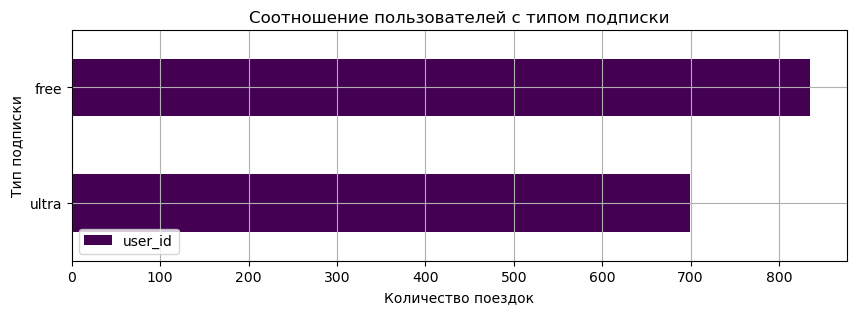

,subscription_type,user_id
0,free,835
1,ultra,699


In [28]:
users_subs = users.pivot_table(index='subscription_type', 
                                values='user_id', 
                                aggfunc='count').reset_index()
users_subs = users_subs.sort_values(by='user_id', ascending=True)

colors = plt.cm.viridis(range(len(users_subs)))
users_subs.plot(x='subscription_type', 
                kind='barh', 
                figsize=(10, 3), 
                grid=True, 
                color=colors) 

plt.title('Соотношение пользователей с типом подписки')
plt.xlabel('Количество поездок')
plt.ylabel('Тип подписки')
plt.legend(loc='lower left')
plt.show()

display(users_subs.sort_values(by='user_id', ascending=False))

**Вывод:**

*Без подписки:* 835 пользователей имеют бесплатную подписку.

*Подписка "ultra":* 699 пользователей имеют платную подписку.

### Анализ возраста пользователей

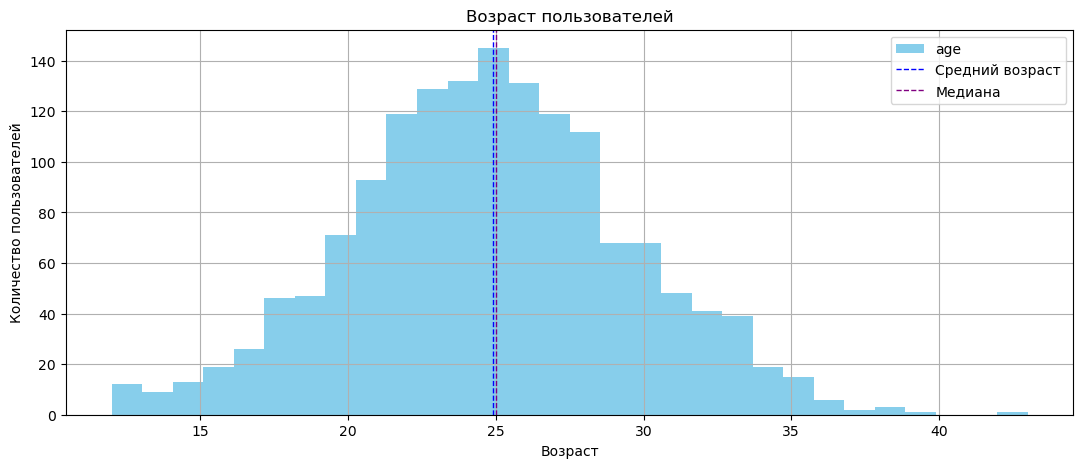

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [31]:
ax = users['age'].plot(kind='hist', grid=True, figsize=(13, 5), bins=30, color='skyblue')

mean_age = users['age'].mean()
median_age = users['age'].median()

plt.axvline(mean_age, color='blue', linestyle='dashed', linewidth=1, label='Средний возраст')
plt.axvline(median_age, color='purple', linestyle='dashed', linewidth=1, label='Медиана')

plt.legend()

plt.title('Возраст пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')

plt.show()

display(users['age'].describe())

**Вывод:**

Средний возраст 24.9 года, что указывает на то, что большинство пользователей находятся в молодом возрасте.

Стандартное отклонение 4.57 года, что говорит о том, что возраст пользователей варьируется относительно не сильно вокруг среднего значения.

Минимальный возраст составляет 12 лет, а максимальный — 43 года. Это указывает на наличие как очень молодых, так и более взрослых пользователей.

Распределение данных по возрасту пользователей является нормальным, это означает, что большинство пользователей сосредоточены вокруг среднего возраста, и количество пользователей с возрастом, значительно отличающимся от среднего, будет уменьшаться. 

Таким образом, можно заключить, что аудитория в основном молода, с небольшими колебаниями в возрасте, и распределение возрастов, является симметричным вокруг среднего значения.

### Визуализация и анализ расстояния, которое пользователь преодолел за одну поездку

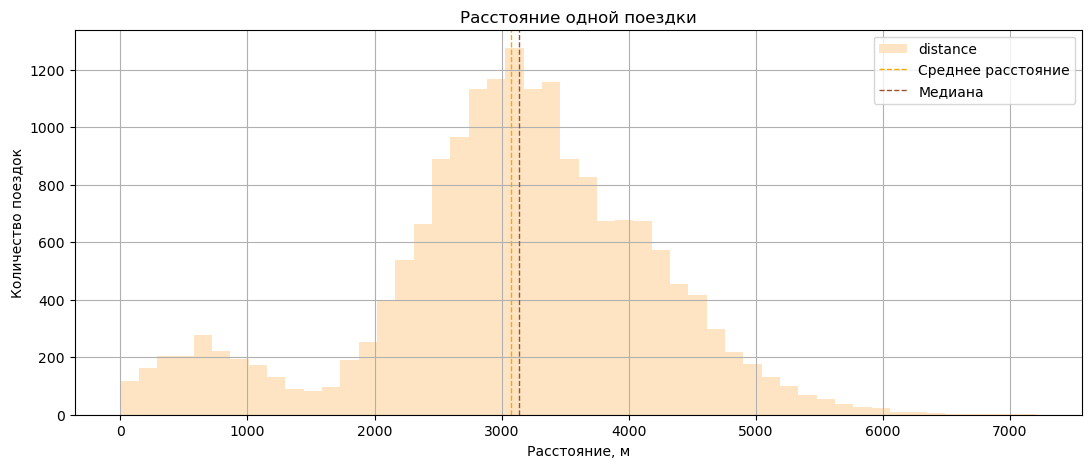

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [34]:
ax = rides['distance'].plot(kind='hist', grid=True, figsize=(13, 5), bins=50, color='bisque')

mean_distance = rides['distance'].mean()
median_distance = rides['distance'].median()

plt.axvline(mean_distance, color='orange', linestyle='dashed', linewidth=1, label='Среднее расстояние')
plt.axvline(median_distance, color='sienna', linestyle='dashed', linewidth=1, label='Медиана')

plt.legend()

plt.title('Расстояние одной поездки')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')

plt.show()

display(rides['distance'].describe())

**Вывод:**

Среднее расстояние поездки составляет примерно 3070.66 метров, что указывает на то, что в целом пользователи предпочитают более длинные поездки.

На графике наблюдаются две явные пики: первая около 700 метров, а вторая около 3000 метров. Это может указывать на два основных типа поездок:

Короткие поездки: Пик на уровне 700 метров может свидетельствовать о том, что многие пользователи берут самокаты для коротких поездок, например, для перемещения на небольшие расстояния, таких как поездки по городу или до ближайшего магазина, или же берут самокат впервые, чтобы попробовать покататься.

Длинные поездки: Пик на уровне 3000 метров может указывать на то, что пользователи также используют самокаты для более длительных поездок, возможно, для поездок на работу или в учебные заведения.

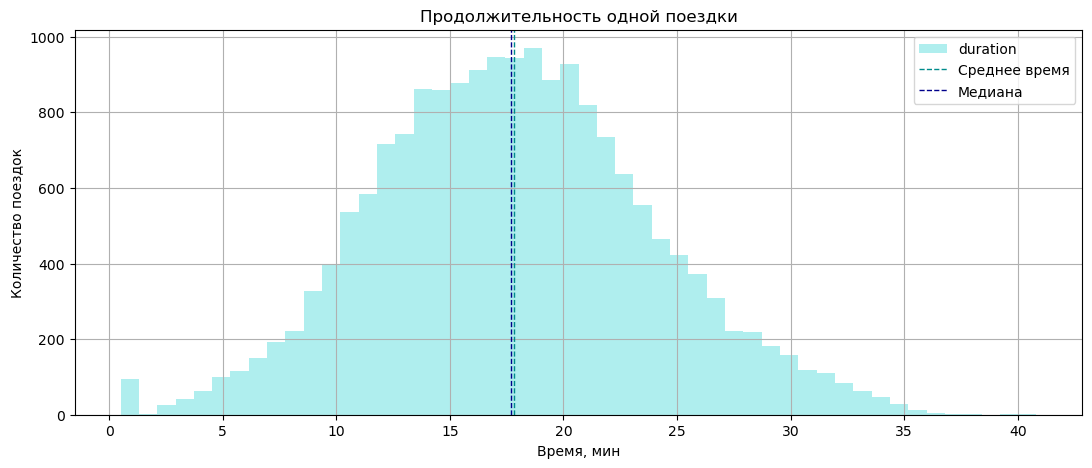

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [36]:
ax = rides['duration'].plot(kind='hist', grid=True, figsize=(13, 5), bins=50, color='paleturquoise')

mean_duration = rides['duration'].mean()
median_duration = rides['duration'].median()

plt.axvline(mean_duration, color='darkcyan', linestyle='dashed', linewidth=1, label='Среднее время')
plt.axvline(median_duration, color='darkblue', linestyle='dashed', linewidth=1, label='Медиана')

plt.legend()

plt.title('Продолжительность одной поездки')
plt.xlabel('Время, мин')
plt.ylabel('Количество поездок')

plt.show()

display(rides['duration'].describe())

**Вывод:**

Среднее время и медиана поездки составляют примерно 17.81 и 17.68 минут, соответственно, что указывает на то, что в целом пользователи проводят около 18 минут в пути.

Стандартное отклонение равно 6.09 минут, что указывает на то, что продолжительность поездок варьируется относительно среднего значения.
График:

На графике распределения продолжительности поездок можно наблюдать, что данные имеют форму, близкую к нормальному распределению (распределению Гаусса). Это говорит о том, что большинство поездок имеют продолжительность, близкую к среднему значению, с меньшим количеством очень коротких и очень длинных поездок.

## Объединение датафреймов  и анализ данных

Для дальшейшей работы с данным, удобней будет объединить датафреймы о пользователях, поездках и подписках в один. Затем разделить полученный датафрем на два: с подпиской и без. А затем проанализированить полученные датафреймы.

In [40]:
data = rides.copy()
data = data.merge(users, 
                  how = 'left', 
                  on = 'user_id')
data = data.merge(subscriptions, 
                  how = 'left', 
                  on='subscription_type')
display(data.head())

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [41]:
data_free = data[data['subscription_type'] == 'free']
display(data_free.head())

print('Количество строк в датасете data_free:', data_free.shape[0])

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
6500,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
6501,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
6502,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
6503,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
6504,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0


Количество строк в датасете data_free: 11568


In [42]:
data_ultra = data[data['subscription_type'] == 'ultra']
display(data_ultra.head())

print('Количество строк в датасете data_ultra:', data_ultra.shape[0])

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


Количество строк в датасете data_ultra: 6500


### Сравнительный анализ расстояния одной поездки для пользователей с подпиской и без 

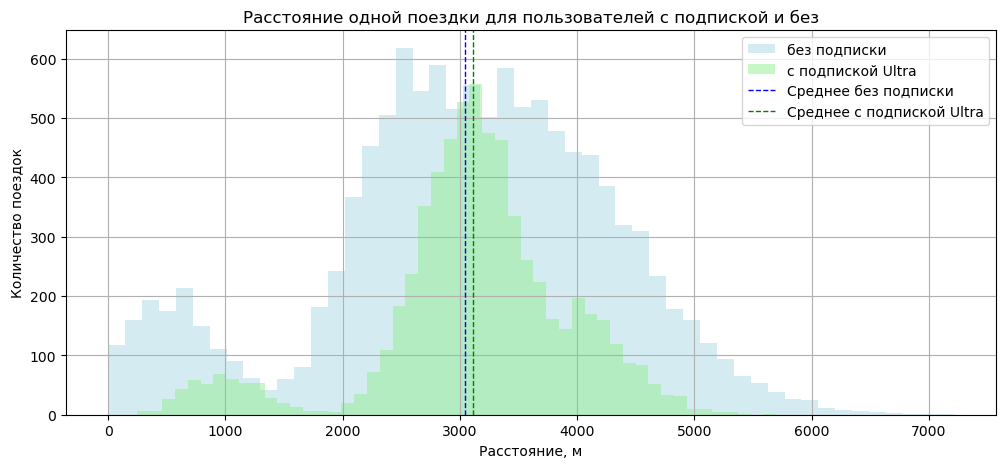

------------------------------------------------------------------------------------------------------------------------------------------------------
Информация о пользователях без подписки:


count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64


------------------------------------------------------------------------------------------------------------------------------------------------------
Информация о пользователях с подпиской:


count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [44]:
ax = data_free['distance'].plot(kind='hist', grid=True, figsize=(12, 5), bins=50, 
                                  color='lightblue', alpha=0.5, label='без подписки')

data_ultra['distance'].plot(kind='hist', grid=True, figsize=(12, 5), bins=50, 
                             color='lightgreen', alpha=0.5, label='с подпиской Ultra', ax=ax)

mean_free = data_free['distance'].mean()
mean_ultra = data_ultra['distance'].mean()

plt.axvline(mean_free, color='blue', linestyle='dashed', linewidth=1, label='Среднее без подписки')
plt.axvline(mean_ultra, color='green', linestyle='dashed', linewidth=1, label='Среднее с подпиской Ultra')

plt.title('Расстояние одной поездки для пользователей с подпиской и без')
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.legend(loc='upper right')

plt.show()

print('-' * 150)
print('Информация о пользователях без подписки:')
display(data_free.distance.describe())
print()
print('-' * 150)
print('Информация о пользователях с подпиской:')
display(data_ultra.distance.describe())

### Сравнительный анализ продолжительности одной поездки для пользователей с подпиской и без 

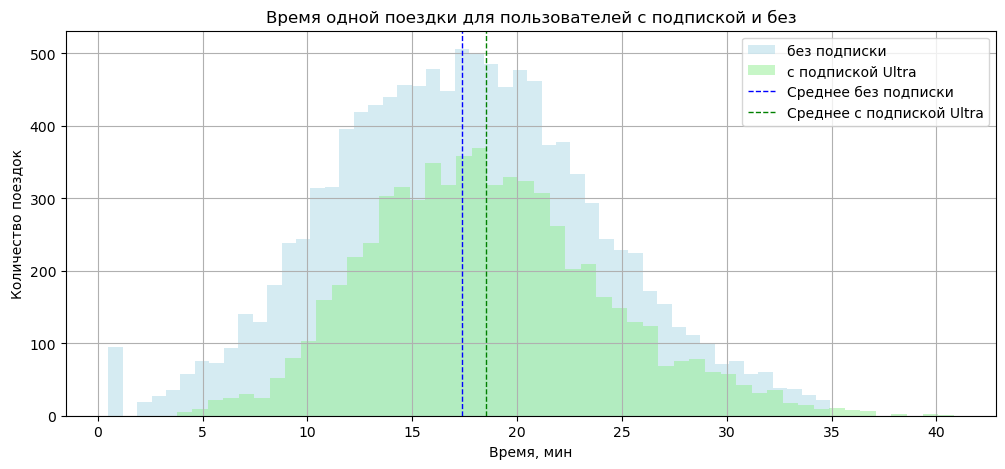

------------------------------------------------------------------------------------------------------------------------------------------------------
Информация о пользователях без подписки:


count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64


------------------------------------------------------------------------------------------------------------------------------------------------------
Информация о пользователях с подпиской:


count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

In [46]:
ax = data_free['duration'].plot(kind='hist', grid=True, figsize=(12, 5), bins=50, 
                                  color='lightblue', alpha=0.5, label='без подписки')

data_ultra['duration'].plot(kind='hist', grid=True, figsize=(12, 5), bins=50, 
                             color='lightgreen', alpha=0.5, label='с подпиской Ultra', ax=ax)

mean_free = data_free['duration'].mean()
mean_ultra = data_ultra['duration'].mean()

plt.axvline(mean_free, color='blue', linestyle='dashed', linewidth=1, label='Среднее без подписки')
plt.axvline(mean_ultra, color='green', linestyle='dashed', linewidth=1, label='Среднее с подпиской Ultra')

plt.title('Время одной поездки для пользователей с подпиской и без')
plt.xlabel('Время, мин')
plt.ylabel('Количество поездок')
plt.legend(loc='upper right')

plt.show()

print('-' * 150)
print('Информация о пользователях без подписки:')
display(data_free.duration.describe())
print()
print('-' * 150)
print('Информация о пользователях с подпиской:')
display(data_ultra.duration.describe())

**Вывод:**

На этом этапе были объеденены все данные в одну таблицу и выделели отдельно пользователей с подпиской и без подписки. 

В результате анализа данных выявили, что пользователи без подписки чаще ездят на короткие расстояния, на длинные растояния пользователи ездят сопоставимо одинаково. Есть всплеск по очень коротким поездкам без подписки - видимо пробные с целью знакомства с сервисом. Поездок без подписки больше, но в целом распределение поездок по времнни можно определить как нормальное.

### Подсчет выручки

Для подсчета выручки создадим новый датафрем. Для начала округлим время поездки до целого числа и приведем в типу int. Затем поздадим новый датафрейм со следующими столбцами:

* count_distance - количество поездок за месяц;
* sum_distance - общая дистанция за месяц;
* sum_duration - общая продолжительность поездок за месяц.

В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого обратимся к информации об условиях оплаты для подписчиков и тех, у кого нет подписки. Продолжительность каждой поездки в каждой строке исходного датафрейма для подсчёта стоимости округлим до следующего целого числа: например, значения 25.3, 25.5 и 26.0 должны быть преобразованы к 26.

In [50]:
data['duration'] = np.ceil(data['duration'])
data['duration'] = data['duration'].astype('int')

In [51]:
data_agg = data.pivot_table(index= ['user_id', 'month'], 
                            values = ['distance', 'duration'], 
                            aggfunc = ['count', 'sum'])
data_agg.columns = ['_'.join(col) for col in data_agg.columns.values]
data_agg = data_agg.drop(columns=['count_duration'])
data_agg = data_agg.reset_index()
display(data_agg.head())

,user_id,month,count_distance,sum_distance,sum_duration
0,1,1,2,7027.511294,42
1,1,4,1,754.159807,7
2,1,8,2,6723.470560,46
3,1,10,2,5809.911100,32
4,1,11,3,7003.499363,56


In [52]:
data_agg = data_agg.merge(users, 
                          how='left', 
                          on='user_id')
data_agg = data_agg.merge(subscriptions, 
                          how = 'left', 
                          on='subscription_type')
display(data_agg.head())

,user_id,month,count_distance,sum_distance,sum_duration,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,2,7027.511294,42,Кира,22,Тюмень,ultra,6,0,199
1,1,4,1,754.159807,7,Кира,22,Тюмень,ultra,6,0,199
2,1,8,2,6723.470560,46,Кира,22,Тюмень,ultra,6,0,199
3,1,10,2,5809.911100,32,Кира,22,Тюмень,ultra,6,0,199
4,1,11,3,7003.499363,56,Кира,22,Тюмень,ultra,6,0,199


In [53]:
data_agg['gain'] = data_agg.apply(gain, axis=1)

display(data_agg[['user_id', 'name', 'month', 'gain']])

,user_id,name,month,gain
0,1,Кира,1,451
1,1,Кира,4,241
2,1,Кира,8,475
3,1,Кира,10,391
4,1,Кира,11,535
...,...,...,...,...
11326,1534,Альберт,6,308
11327,1534,Альберт,8,484
11328,1534,Альберт,9,234
11329,1534,Альберт,11,824


## Проверка гипотез

**Первая гипотеза:**

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу. Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

* *Нулевая теория:* среднее время поездок пользователей с подпиской и пользователей без подписки равны
* *Альтернативная гипотеза:* пользователи с подпиской тратят больше времени

In [56]:
alpha = 0.05 

results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')

print('p-значение:', round((results.pvalue), 50))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу


In [57]:
print('Среднее время поездки пользователей c подпиской:', round(data_ultra['duration'].mean(),2))
print('Среднее время поездки пользователей без подписки:', round(data_free['duration'].mean(),2))

Среднее время поездки пользователей c подпиской: 18.54
Среднее время поездки пользователей без подписки: 17.39


**Вывод:**

Результаты показывают, что пользователи с подпиской действительно тратят больше времени на поездки по сравнению с пользователями без подписки. Это может указывать на то, что пользователи с подпиской более активно используют сервис по самокатам, что может быть выгодно для компании.

**Вторая гипотеза:**

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим данную гипотезу и сделаем выводы.

* *Нулевая гипотеза:* среднее расстояние поездки пользователей с подпиской равно 3130 метров.
* *Альтернативная гипотеза:* среднее расстояние поездки пользователей с подпиской больше 3130 метров.

In [60]:
interested_value = 3130 # столько времени должны проводить пользователи на сайте

alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(data_ultra['distance'], interested_value, alternative='greater')

print('p-значение:', round((results.pvalue), 2))

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.92
Не получилось отвергнуть нулевую гипотезу


In [61]:
print('Среднее дистанция поездки пользователей c подпиской:', round(data_ultra['distance'].mean(),0))

Среднее дистанция поездки пользователей c подпиской: 3115.0


**Вывод:**

На основании проведенного анализа нет достаточных оснований утверждать, что среднее расстояние поездки пользователей с подпиской превышает 3130 метров. Это может указывать на то, что пользователи с подпиской не превышают оптимальное расстояние, что может быть важно для оценки износа самокатов.

**Третья гипотеза:**

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

* *Нулевая гипотеза:* помесячная выручка от пользователей с подпиской и без равны.
* *Альтернативная гипотеза:* помесячная выручка от пользователей с подпиской выше чем выручка от пользователей без подписки

In [64]:
# создадим две выборки с посчитанной помесячной выручкой
data_agg_ultra = data_agg[data_agg['subscription_type'] == 'ultra']
data_agg_free = data_agg[data_agg['subscription_type'] == 'free']

alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(data_agg_ultra['gain'], data_agg_free['gain'], alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


In [65]:
print('Средняя помесячная выручка от пользователи с подпиской:', round(data_agg_ultra['gain'].mean(),2))
print('Средняя помесячная выручка от пользователи без подписки:', round(data_agg_free['gain'].mean(),2))

Средняя помесячная выручка от пользователи с подпиской: 362.79
Средняя помесячная выручка от пользователи без подписки: 328.64


**Вывод:**

Результаты показывают, что помесячная выручка от пользователей с подпиской действительно выше, чем выручка от пользователей без подписки. 
Поскольку нулевая гипотеза отвергнута, далем вывод, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Таким образом, на основе проведенного анализа можно сделать вывод, что пользователи с подпиской являются более ценными для компании с точки зрения выручки.

# Дополнительные вопросы

**Задание 1**

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберем параметры распределения, описывающего эту ситуацию, построем график распределения и сформулируем ответ на вопрос о количестве промокодов.

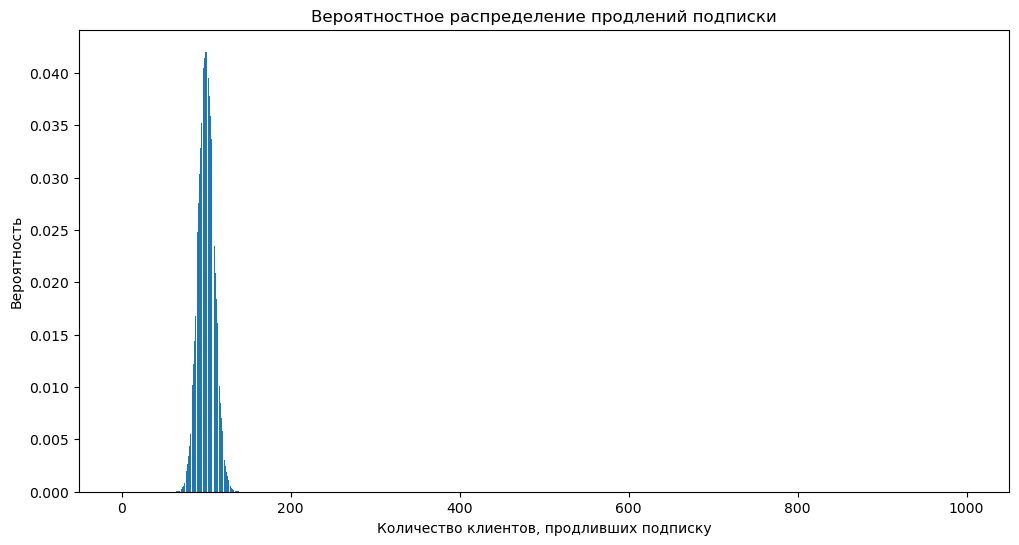

In [128]:
n = 1000
p = 0.1
distr = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k)
    distr.append(prob)

plt.figure(figsize=(12, 6))  
plt.bar(range(0, n + 1), distr)  
plt.xlabel('Количество клиентов, продливших подписку') 
plt.ylabel('Вероятность')  
plt.title('Вероятностное распределение продлений подписки')
plt.show()

In [140]:
# В диапазоне (n-500, n+500) определим минимальное количество промокодов,
# чтобы вероятность не выполнить план была не больше 5%

for n in range (500, 1500):
    if binom.cdf(99, n, p) < 0.05:
        print("Минимальное число промокодов:", n)
        break

Минимальное число промокодов: 500


**Вывод:**

Для акции раздачи промокодов с целью получения не менее 100 продлений подписок, с вероясностью невыполнения не больше 5% нужно сделать рассылку менее 1161 промокодов

**Задание 2**

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации построем примерный график распределения и оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [132]:
# Аппроксимируем биномиальное распределение нормальным и посчитаем
# задаём параметры биномиального распределения

n = 1000000
p = 0.4

mu = n * p
sigma = sqrt(n * p * (1 - p))
# задаём нормальное распределение
distr = st.norm(mu, sigma)

x = 399500

# считаем вероятность получить значение, равное x или меньше
result = distr.cdf(x)

print('Вероятность что push-уведомления откроют не более 399,5 тыс. пользователей:',
      round(result, 2))

Вероятность что push-уведомления откроют не более 399,5 тыс. пользователей: 0.15


**Вывод:**

В условиях акции рассылки 1 млн. push-уведомлений вероятность что откроют их не более 399,5 тыс. пользователей - 15%

## Общий вывод



На этапе подготовки данных проведена предобработка данных: проверила датафреймах на наличие пропусков, полных дубликатов и соответствие типов данных. Пропусков и дубликатов нет, исправила тип данных столбца date и добавила новый столбец с номером месяца для удобства анализа в дальнейшем. 
При анализе данных определила, что в выборке представлено 8 городов со среднем числом пользователей 191 человек. 

Пользователей с подпиской ultra меньше (45,5%), чем без подписки free (55,5%), но не значительно. 

Соотношение пользователей с подпиской и без
    
ULTRA  | FREE
------ | ------
45,5%  | 55,5%


Выявили, что в среднем одна поездка длится 18 минут и пользователи преодолевают примерно 3 км.

Сведя все данные в одну таблицы, выявили, что пользователи без подписки чаще используют самокаты для коротких поездок, что объяснимо, на более длительные  поездки пользователи ездят сопоставимо одинаково. 

Поездок без подписки больше, но в целом распределение поездок по времени можно определить как нормальное.

Выявили, что пользователи с подпиской тратят в среднем на 1 минуту больше времени, чем пользователей без подписки. Таким образом пользователи с подпиской не на много выгоднее для компании, чем пользователи без подписки. 

Расстояние одной поездки в  3130 метров — оптимальное с точки зрения износа самоката. При анализе данных рассчитали что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 и составляет в среднем  3115 м. Т.е. поездки подписчиков не причиняют повышенный износ самокатам и, следовательно, не приносят убытки длинными поездками.

Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки - данная гипотеза получила подтверждение.

В целях увеличения прибыли сервису стоит искать пути привлечения пользователей оформлять подписку, поскольку они приносят больше прибыли , используя самокаты на более долгие поездки, но при этом не нанося излишний износ самокатам.